# Taxi Trips and Traffic

Where most models use real-time data from users to predict arrival
times at any given moment, we believe they could be improved by including a predictive
element. Our intent is to use the NYC Taxi and Limousine Commission's yellow and green cab data set to estimate density of pickup and dropoffs at any given place and time. We will then use the density as a proxy for traffic to estimate the time it takes to arrive at a destination.

In [2]:
%matplotlib inline
import edward as ed
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from setup import set_random_seeds
import data
# set_random_seeds(42)
plt.style.use("seaborn-talk")
sns.set_context("talk")

## Data

Use the
[2015 NYC Yellow Cab Dataset](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml),
which consists of pickup and dropoff coordinates for trips, along 
with metadata like cost, distance, and number of passengers. For the time being, we are only interested in trips that occurr entirely within the range from 1st street to 59th street, and 12th ave to 1st ave, during the month of april. This data can be easily visualized as 2d plot.

```SQL
SELECT
  *
FROM
  [bigquery-public-data:new_york.tlc_yellow_trips_2016]
WHERE
  (pickup_longitude > -74.0124053955
    AND pickup_longitude < -73.9673309326)
  AND (pickup_latitude > 40.7186431885
    AND pickup_latitude < 40.7735137939)
  AND (dropoff_longitude > -74.0124053955
    AND dropoff_longitude < -73.9673309326)
  AND (dropoff_latitude > 40.7186431885
    AND dropoff_latitude < 40.7735137939)
  AND TIMESTAMP_TO_MSEC(pickup_datetime) > 1459483200000
  AND TIMESTAMP_TO_MSEC(dropoff_datetime) < 1462075200000
  order by pickup_datetime desc
LIMIT
  10000
```

In [3]:
data_raw = pd.read_csv('datasets/train.csv')

In [4]:
""" Function drops unnecessary metadata in raw dataset"""
def getCleanTaxiData(data_raw):
    # Drop unneccessary meta data
    dataset = data_raw.loc[:, 'pickup_datetime':'trip_duration']
    dataset.drop('passenger_count', axis=1, inplace=True)
    dataset.drop('store_and_fwd_flag', axis=1, inplace=True)

    # Rename columns
    dataset.columns=[['pickup_datetime','dropoff_datetime','pickup_longitude',
                      'pickup_latitude','dropoff_longitude','dropoff_latitude',
                      'time']]

    # Convert date/time into two columns
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'])
    dataset['pickup_date'] = dataset['pickup_datetime'].dt.date
    dataset['pickup_time'] = dataset['pickup_datetime'].dt.time

    dataset['dropoff_datetime'] = pd.to_datetime(dataset['dropoff_datetime'])
    dataset['dropoff_date'] = dataset['dropoff_datetime'].dt.date
    dataset['dropoff_time'] = dataset['dropoff_datetime'].dt.time

    dataset.drop('pickup_datetime', axis=1, inplace=True)
    dataset.drop('dropoff_datetime', axis=1, inplace=True)
    
    return dataset

# ... could take a ~1-2 minutes
dataset = getCleanTaxiData(data_raw)
# View first 5 rows of dataset using pandas df.head()
dataset.head()




,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,time,pickup_date,pickup_time,dropoff_date,dropoff_time
0,-73.982155,40.767937,-73.964630,40.765602,455,2016-03-14,17:24:55,2016-03-14,17:32:30
1,-73.980415,40.738564,-73.999481,40.731152,663,2016-06-12,00:43:35,2016-06-12,00:54:38
2,-73.979027,40.763939,-74.005333,40.710087,2124,2016-01-19,11:35:24,2016-01-19,12:10:48
3,-74.010040,40.719971,-74.012268,40.706718,429,2016-04-06,19:32:31,2016-04-06,19:39:40
4,-73.973053,40.793209,-73.972923,40.782520,435,2016-03-26,13:30:55,2016-03-26,13:38:10


In [5]:
import json

with open('nyc_neighborhoods.json') as file:
    json_data = json.load(file)

In [6]:
from shapely.geometry import shape, Point

""" 
Function takes a geo/json file of NYC census tracts and returns
neighborhoods.... works in general but need to fix so clearly returns
pickup/dropoff neighborhood & just appends that to main dataframe
.... so tired...
"""

# This only returns 1 column... need to fix so returns neighborhood for both pickup/dropoff
def getRoundedLonLat(dataset):
    locations = pd.DataFrame(columns = ['rounded_lon', 'rounded_lat'])
    # Collect all unique rounded pickup/dropoff coords
    decimals = 3
    tmp1 = dataset[['pickup_longitude', 'pickup_latitude']].round(decimals)
    tmp2 = dataset[['dropoff_longitude', 'dropoff_latitude']].round(decimals)
    tmp1.columns = ['rounded_lon', 'rounded_lat']
    tmp2.columns = ['rounded_lon', 'rounded_lat']
    tmp_locs = pd.concat([tmp1, tmp2], ignore_index=True)
    tmp_locs.drop_duplicates(inplace=True)
    locations = pd.concat([locations, tmp_locs], ignore_index=True)
    locations.drop_duplicates(inplace=True)
    
    # Drop NAs, sort coords to make lookups faster
    locations.dropna(inplace=True)
    locations = locations.sort_values(['rounded_lon', 'rounded_lat']).reset_index()[['rounded_lon', 'rounded_lat']]
    
    return locations


def getNeighborhoods(json_data, dataset):
    
#     poly_bounds = np.empty((0))
#     for feature in json_data['features']:
#         check_coords = feature['geometry']['coordinates'][0]
#         poly_bounds = np.append(poly_bounds, [item for item in check_coords])
#     poly_bounds = poly_bounds.flatten()
#     min_lat = min(poly_bounds[poly_bounds > 0])
#     max_lat = max(poly_bounds[poly_bounds > 0])
#     min_lon = min(poly_bounds[poly_bounds < 0])
#     max_lon = max(poly_bounds[poly_bounds < 0])
    
    # defaults from mike
    min_lat =  40.7186431885
    max_lat =  40.7735137939
    min_lon = -74.0124053955
    max_lon = -73.9673309326
 
    hoods = []
    feature = json_data['features'][0]
    
    # Return sorted rounded latitudes/longitudes dataframe
    locations = getRoundedLonLat(dataset)


    # check each polygon to see if it contains the point
    # try the previous point's hood first, since the points are sorted
    for x, row1 in locations.iterrows():
        
        temp_point = Point(locations.rounded_lon[x], locations.rounded_lat[x])
        hoods.append(np.nan)
        
        if(min_lon < locations.rounded_lon[x] < max_lon) and (min_lat < locations.rounded_lat[x] < max_lat):
                temp_polygon = shape(feature['geometry'])
                if temp_polygon.contains(temp_point):
                    if feature['properties']['borough'] == 'Manhattan':
                        hoods[x] = feature['properties']['neighborhood']
                    else:
                        hoods[x] = 'NaN'
                        
                else:
                    for feature in json_data['features']:
                        if feature['properties']['borough'] == 'Manhattan':
                            polygon = shape(feature['geometry'])
                            if polygon.contains(temp_point):
                                hoods[x] = feature['properties']['neighborhood']
                                break
                        
    locations['neighborhood'] = hoods
    locations = locations.dropna().reset_index(drop=True)
    return locations
        

In [39]:
from shapely.geometry import shape, Point

""" 
Function takes a geo/json file of NYC census tracts and returns
neighborhoods.... works in general but need to fix so clearly returns
pickup/dropoff neighborhood & just appends that to main dataframe
.... so tired...
"""

def getRoundedLonLat(dataset):
    decimals = 6
    dataset['pickup_rounded_lon'] = dataset[['pickup_longitude']].round(decimals)
    dataset['pickup_rounded_lat'] = dataset[['pickup_latitude']].round(decimals)
    dataset['dropoff_rounded_lon'] = dataset[['dropoff_longitude']].round(decimals)
    dataset['dropoff_rounded_lat'] = dataset[['dropoff_latitude']].round(decimals)

    
    dataset = dataset.sort_values(['pickup_rounded_lon', 'pickup_rounded_lat','dropoff_rounded_lon', 'dropoff_rounded_lat']).reset_index()[['pickup_rounded_lon', 'pickup_rounded_lat','dropoff_rounded_lon', 'dropoff_rounded_lat']]
    
    return dataset


def checkPointBounds(point):
    # check if point is in Manhattan bound
    # defaults from mike - kinda stringent and lead to a bunch of NaNs
    point_lon = point[0]
    point_lat = point[1]
    min_lon =  40.7186431885
    max_lon =  40.7735137939
    min_lat = -74.0124053955
    max_lat = -73.9673309326

    if(min_lon < point_lon < max_lon) and (min_lat <  point_lat < max_lat):
        return True
    else:
        return False

       
def getNeighborhood(point, json_data):

    temp_point = Point(point[1],point[0])
    #print(temp_point)

    #if (checkPointBounds(point)):
    if (True):
            for feature in json_data['features']:
                if feature['properties']['borough'] == 'Manhattan':
                    polygon = shapely.geometry.asShape(feature['geometry'])
                    if polygon.contains(temp_point):
                        return feature['properties']['neighborhood']
                else:
                    continue
        
    return 'NaN'
                        
    
def addNeighborhoods(dataset, json_data):

    temp_data = getRoundedLonLat(dataset)
    temp_data['pickup_neighborhood'] = ""
    temp_data['dropoff_neighborhood'] = ""
    drops = []
    picks = []
    
    for idx, row in temp_data.iterrows():
        pickup_point = (temp_data.pickup_rounded_lat[idx],temp_data.pickup_rounded_lon[idx])
        
        phood = getNeighborhood(pickup_point, json_data)

        dropoff_point = (temp_data.dropoff_rounded_lat[idx], temp_data.dropoff_rounded_lon[idx])
        dhood = getNeighborhood(dropoff_point, json_data)
        print("dropoff: ", dropoff_point)
        print("dropoff: ", dhood)
        print("pickup: ", pickup_point)
        print("pickup: ", phood)
        print("\n")
        
    #print(temp_data.head())

        

In [ ]:

addNeighborhoods(dataset.loc[0:5000], json_data)

/Users/colbywise/anaconda2/envs/pp/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/colbywise/anaconda2/envs/pp/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/colbywise/anaconda2/envs/pp/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



dropoff:  (40.816853000000002, -74.209854000000007)
dropoff:  NaN
pickup:  (40.816853000000002, -74.209854000000007)
pickup:  NaN


dropoff:  (40.690280999999999, -74.177779999999998)
dropoff:  NaN
pickup:  (40.690280999999999, -74.177779999999998)
pickup:  NaN


dropoff:  (40.708187000000002, -74.001891999999998)
dropoff:  Financial District
pickup:  (40.709437999999999, -74.018073999999999)
pickup:  Battery Park City


dropoff:  (40.757461999999997, -73.976662000000005)
dropoff:  Midtown
pickup:  (40.706519999999998, -74.017807000000005)
pickup:  Battery Park City


dropoff:  (40.750660000000003, -73.978736999999995)
dropoff:  Murray Hill
pickup:  (40.706532000000003, -74.017753999999996)
pickup:  Battery Park City


dropoff:  (40.761566000000002, -73.973929999999996)
dropoff:  Midtown
pickup:  (40.705359999999999, -74.017302999999998)
pickup:  Battery Park City


dropoff:  (40.761355999999999, -73.979927000000004)
dropoff:  Theater District
pickup:  (40.708477000000002, -74.01725000

pickup:  (40.713588999999999, -74.014197999999993)
pickup:  Battery Park City


dropoff:  (40.722110999999998, -74.011825999999999)
dropoff:  Tribeca
pickup:  (40.713687999999998, -74.014197999999993)
pickup:  Battery Park City


dropoff:  (40.760677000000001, -73.991020000000006)
dropoff:  Hell's Kitchen
pickup:  (40.713821000000003, -74.013962000000006)
pickup:  Battery Park City


dropoff:  (40.718074999999999, -73.997551000000001)
dropoff:  Little Italy
pickup:  (40.712833000000003, -74.013953999999998)
pickup:  Battery Park City


dropoff:  (40.720219, -73.957329000000001)
dropoff:  NaN
pickup:  (40.713977999999997, -74.013779)
pickup:  Battery Park City


dropoff:  (40.752453000000003, -73.983894000000006)
dropoff:  Midtown
pickup:  (40.712769000000002, -74.013687000000004)
pickup:  Financial District


dropoff:  (40.760657999999999, -73.979973000000001)
dropoff:  Theater District
pickup:  (40.708061000000001, -74.013679999999994)
pickup:  Financial District


dropoff:  (40.75782

dropoff:  (40.770755999999999, -73.981933999999995)
dropoff:  Upper West Side
pickup:  (40.736266999999998, -74.009795999999994)
pickup:  West Village


dropoff:  (40.719028000000002, -73.836533000000003)
dropoff:  NaN
pickup:  (40.712364000000001, -74.009788999999998)
pickup:  Tribeca


dropoff:  (40.760886999999997, -73.971474000000001)
dropoff:  Midtown
pickup:  (40.720978000000002, -74.009788999999998)
pickup:  Tribeca


dropoff:  (40.691977999999999, -73.984932000000001)
dropoff:  NaN
pickup:  (40.720390000000002, -74.009711999999993)
pickup:  Tribeca


dropoff:  (40.728836000000001, -73.999595999999997)
dropoff:  Greenwich Village
pickup:  (40.739654999999999, -74.009704999999997)
pickup:  West Village


dropoff:  (40.714851000000003, -74.015502999999995)
dropoff:  Battery Park City
pickup:  (40.712848999999999, -74.009665999999996)
pickup:  Tribeca


dropoff:  (40.730488000000001, -73.986136999999999)
dropoff:  East Village
pickup:  (40.738770000000002, -74.009658999999999)
pick

dropoff:  (40.735439, -73.996712000000002)
dropoff:  Greenwich Village
pickup:  (40.731009999999998, -74.008171000000004)
pickup:  West Village


dropoff:  (40.804836000000002, -73.955093000000005)
dropoff:  Harlem
pickup:  (40.745002999999997, -74.008171000000004)
pickup:  Chelsea


dropoff:  (40.712307000000003, -73.989922000000007)
dropoff:  Lower East Side
pickup:  (40.740513, -74.008162999999996)
pickup:  West Village


dropoff:  (40.759548000000002, -73.972487999999998)
dropoff:  Midtown
pickup:  (40.722141000000001, -74.008140999999995)
pickup:  Tribeca


dropoff:  (40.742545999999997, -73.993080000000006)
dropoff:  Chelsea
pickup:  (40.722408000000001, -74.008140999999995)
pickup:  Tribeca


dropoff:  (40.743068999999998, -73.991371000000001)
dropoff:  Flatiron District
pickup:  (40.740336999999997, -74.008133000000001)
pickup:  West Village


dropoff:  (40.725082, -73.995377000000005)
dropoff:  NoHo
pickup:  (40.730651999999999, -74.008117999999996)
pickup:  West Village


dro

dropoff:  (40.702311999999999, -73.986732000000003)
dropoff:  NaN
pickup:  (40.740031999999999, -74.007095000000007)
pickup:  West Village


dropoff:  (40.720001000000003, -74.008376999999996)
dropoff:  Tribeca
pickup:  (40.707965999999999, -74.007026999999994)
pickup:  Financial District


dropoff:  (40.740172999999999, -74.005898000000002)
dropoff:  West Village
pickup:  (40.739871999999998, -74.007003999999995)
pickup:  West Village


dropoff:  (40.662998000000002, -73.988617000000005)
dropoff:  NaN
pickup:  (40.704825999999997, -74.006966000000006)
pickup:  Financial District


dropoff:  (40.728340000000003, -74.005257)
dropoff:  SoHo
pickup:  (40.716320000000003, -74.006950000000003)
pickup:  Tribeca


dropoff:  (40.717506, -73.995330999999993)
dropoff:  Chinatown
pickup:  (40.707920000000001, -74.006919999999994)
pickup:  Financial District


dropoff:  (40.751857999999999, -73.994995000000003)
dropoff:  Chelsea
pickup:  (40.711796, -74.006919999999994)
pickup:  Civic Center


dro

dropoff:  (40.768593000000003, -73.984748999999994)
dropoff:  Upper West Side
pickup:  (40.739964000000001, -74.005996999999994)
pickup:  West Village


dropoff:  (40.758595, -73.981064000000003)
dropoff:  Midtown
pickup:  (40.742119000000002, -74.005996999999994)
pickup:  Chelsea


dropoff:  (40.763359000000001, -73.992751999999996)
dropoff:  Hell's Kitchen
pickup:  (40.739891, -74.005959000000004)
pickup:  West Village


dropoff:  (40.75956, -73.979552999999996)
dropoff:  Midtown
pickup:  (40.736046000000002, -74.005913000000007)
pickup:  West Village


dropoff:  (40.780422000000002, -73.951644999999999)
dropoff:  Upper East Side
pickup:  (40.706028000000003, -74.005904999999998)
pickup:  Financial District


dropoff:  (40.727271999999999, -73.997330000000005)
dropoff:  Greenwich Village
pickup:  (40.740234000000001, -74.005889999999994)
pickup:  West Village


dropoff:  (40.723503000000001, -73.999640999999997)
dropoff:  SoHo
pickup:  (40.735878, -74.005882)
pickup:  West Village




dropoff:  (40.744514000000002, -73.985564999999994)
dropoff:  Midtown
pickup:  (40.706764, -74.005058000000005)
pickup:  Financial District


dropoff:  (40.791473000000003, -73.977722)
dropoff:  Upper West Side
pickup:  (40.722977, -74.005058000000005)
pickup:  SoHo


dropoff:  (40.702942, -73.929741000000007)
dropoff:  NaN
pickup:  (40.719200000000001, -74.005027999999996)
pickup:  Tribeca


dropoff:  (40.742615000000001, -73.989898999999994)
dropoff:  Flatiron District
pickup:  (40.737395999999997, -74.005027999999996)
pickup:  West Village


dropoff:  (40.745781000000001, -73.972008000000002)
dropoff:  Murray Hill
pickup:  (40.746451999999998, -74.005027999999996)
pickup:  Chelsea


dropoff:  (40.713920999999999, -74.014579999999995)
dropoff:  Battery Park City
pickup:  (40.719048000000001, -74.004974000000004)
pickup:  Tribeca


dropoff:  (40.711300000000001, -74.015923000000001)
dropoff:  Battery Park City
pickup:  (40.730151999999997, -74.004974000000004)
pickup:  West Village




pickup:  Chelsea


dropoff:  (40.735748000000001, -73.987380999999999)
dropoff:  Gramercy
pickup:  (40.733390999999997, -74.003960000000006)
pickup:  West Village


dropoff:  (40.759632000000003, -73.987823000000006)
dropoff:  Theater District
pickup:  (40.738232000000004, -74.003951999999998)
pickup:  West Village


dropoff:  (40.737121999999999, -74.001632999999998)
dropoff:  West Village
pickup:  (40.707580999999998, -74.003936999999993)
pickup:  Financial District


dropoff:  (40.734763999999998, -73.998878000000005)
dropoff:  West Village
pickup:  (40.725796000000003, -74.003928999999999)
pickup:  SoHo


dropoff:  (40.805210000000002, -73.957290999999998)
dropoff:  Harlem
pickup:  (40.742221999999998, -74.003922000000003)
pickup:  Chelsea


dropoff:  (40.809455999999997, -73.953650999999994)
dropoff:  Harlem
pickup:  (40.748268000000003, -74.003922000000003)
pickup:  Chelsea


dropoff:  (40.761333, -73.999504000000002)
dropoff:  Hell's Kitchen
pickup:  (40.741931999999998, -74.003

dropoff:  (40.774796000000002, -73.980887999999993)
dropoff:  Upper West Side
pickup:  (40.760586000000004, -74.002831)
pickup:  Hell's Kitchen


dropoff:  (40.755409, -73.993423000000007)
dropoff:  Hell's Kitchen
pickup:  (40.749557000000003, -74.002823000000006)
pickup:  Chelsea


dropoff:  (40.730415000000001, -73.999763000000002)
dropoff:  Greenwich Village
pickup:  (40.723587000000002, -74.002808000000002)
pickup:  SoHo


dropoff:  (40.762650000000001, -73.993262999999999)
dropoff:  Hell's Kitchen
pickup:  (40.749507999999999, -74.002791999999999)
pickup:  Chelsea


dropoff:  (40.719898000000001, -73.992919999999998)
dropoff:  Lower East Side
pickup:  (40.728119, -74.002776999999995)
pickup:  SoHo


dropoff:  (40.727576999999997, -73.985748000000001)
dropoff:  East Village
pickup:  (40.733767999999998, -74.002769000000001)
pickup:  West Village


dropoff:  (40.753394999999998, -73.996132000000003)
dropoff:  Hell's Kitchen
pickup:  (40.728558, -74.002753999999996)
pickup:  West Vil

dropoff:  (40.738540999999998, -73.984595999999996)
dropoff:  Gramercy
pickup:  (40.735523000000001, -74.001662999999994)
pickup:  West Village


dropoff:  (40.752116999999998, -73.981537000000003)
dropoff:  Midtown
pickup:  (40.756717999999999, -74.001655999999997)
pickup:  Hell's Kitchen


dropoff:  (40.761631000000001, -73.984009)
dropoff:  Theater District
pickup:  (40.756515999999998, -74.001616999999996)
pickup:  Hell's Kitchen


dropoff:  (40.725903000000002, -73.996223000000001)
dropoff:  NoHo
pickup:  (40.740810000000003, -74.001609999999999)
pickup:  Chelsea


dropoff:  (40.728737000000002, -73.988274000000004)
dropoff:  East Village
pickup:  (40.741061999999999, -74.001587000000001)
pickup:  Chelsea


dropoff:  (40.739108999999999, -74.003380000000007)
dropoff:  West Village
pickup:  (40.728619000000002, -74.001579000000007)
pickup:  Greenwich Village


dropoff:  (40.760803000000003, -73.972351000000003)
dropoff:  Midtown
pickup:  (40.741089000000002, -74.001579000000007)
pi

dropoff:  (40.758910999999998, -73.987442000000001)
dropoff:  Theater District
pickup:  (40.732182000000002, -74.000525999999994)
pickup:  Greenwich Village


dropoff:  (40.734943000000001, -73.983315000000005)
dropoff:  Gramercy
pickup:  (40.737288999999997, -74.000495999999998)
pickup:  West Village


dropoff:  (40.725464000000002, -73.983909999999995)
dropoff:  East Village
pickup:  (40.727238, -74.000457999999995)
pickup:  Greenwich Village


dropoff:  (40.747860000000003, -74.000541999999996)
dropoff:  Chelsea
pickup:  (40.742420000000003, -74.000457999999995)
pickup:  Chelsea


dropoff:  (40.672427999999996, -73.915092000000001)
dropoff:  NaN
pickup:  (40.737499, -74.000450000000001)
pickup:  West Village


dropoff:  (40.765929999999997, -73.983413999999996)
dropoff:  Midtown
pickup:  (40.730122000000001, -74.000411999999997)
pickup:  Greenwich Village


dropoff:  (40.765743000000001, -73.955444)
dropoff:  Upper East Side
pickup:  (40.732422, -74.000388999999998)
pickup:  Greenwi

In [36]:
""" Get neighborhoods... tire clean all this shit up tomorrow and make histogram + hourly data ugh 
"""
import shapely

#neighborhoods = getNeighborhoods(json_data, dataset)
#point = (40.7713579,-73.956581)
point = (40.740321999999999, -73.993324000000001)

print( checkPointBounds(point) )
print( getNeighborhood(point,json_data) )
# feature = json_data['features'][0]
#temp_polygon = asShape(feature['geometry'])
# temp_polygon
#print(feature['geometry']['coordinates'][0])
#feats = feature['geometry']['coordinates'][0]

#coords = [tuple(l) for l in feats]
#print(coords)

True
Chelsea


In [18]:
point = (dataset.dropoff_rounded_lon[0], dataset.dropoff_rounded_lat[0])
point[1]


40.765999999999998

In [142]:
hours = dataset['d_time'].loc[0:3]
print(dataset['d_time'].loc[0].hour < 20)

for h in hours:
    if h.hour < 20:
        print(str(h.hour) + ':' + str(h.minute))
        print(True)


True
17:32
True
0:54
True
12:10
True
19:39
True


In [ ]:
dataset.describe()
bins = [0, 120, 240, 360, 480, 600, 720, 840, 960, 1080, 1540]
bins2 = [np.arange(0, 18000, 120)]
bins3 = list(range(0, 10000, 120))
#print(bins3)
counts = pd.cut(dataset['time'], bins3)
dataset['counts'] = pd.cut(dataset['time'], bins3)
x = pd.value_counts(dataset['counts'])
x

In [115]:

""" 
Function takes a geo/json file of NYC census tracts and returns
a dictionary of neighborhoods as keys and values as list of
GPS coordinates within that 'hood' 
"""
def getNeighborhoods(json_data):
    hoods = dict()
    min_lon = dict()
    min_lat = dict()
    max_lon = dict()
    max_lat = dict()
    for tract in json_data['features']:
        if tract['properties']['boro_name'] == 'Manhattan':
            if len(tract['geometry']['coordinates'][0][0]) != 2:
                hoods[tract['properties']['ntaname']] = tract['geometry']['coordinates'][0][0]
            else:
                hoods[tract['ntaname']] = tract['geometry']['coordinates'][0]
            min_lon[tract['properties']['ntaname']] = min([pts[1] for pts in hoods[tract['properties']['ntaname']]])
            max_lon[tract['properties']['ntaname']] = max([pts[1] for pts in hoods[tract['properties']['ntaname']]])
            min_lat[tract['properties']['ntaname']] = min([pts[0] for pts in hoods[tract['properties']['ntaname']]])
            max_lat[tract['properties']['ntaname']] = max([pts[0] for pts in hoods[tract['properties']['ntaname']]])
    
    return hoods, min_lon, min_lat, max_lon, max_lat
        
""" By my rough count we can get rid of ~13-15 of these???
    Which are mainly above 59th street leaving us with 14 hoods 
"""
def findNeighborhood(lat, lon):
    for key,val in neighborhoods.items():
        if min_lat[key] <= lat and min_lon[key] <= lon and max_lat[key] > lat and max_lon[key] >= lon:
                return key
    return None



In [116]:
""" Test of functions. Choosing arbitrary point from neighbor dict and making sure
    findNeighborhood returns same neighborhood when given that point
"""

neighborhoods, min_lon, min_lat, max_lon, max_lat = getNeighborhoods(json_data)

""" By my rough count we can get rid of ~13-15 of these hoods???
    Which are approximately all above 59th street, which would leave us with 14 hoods 
"""
# Show neighborhoods list
#neighborhoods

# Find neighorhood name 
findNeighborhood(-74.01662424491339, 40.7121573189952)

# print( min_lat['Battery Park City-Lower Manhattan'] )
# print( min_lon['Battery Park City-Lower Manhattan'] )
# print( max_lat['Battery Park City-Lower Manhattan'] )
# print( max_lon['Battery Park City-Lower Manhattan'] )


'Battery Park City-Lower Manhattan'

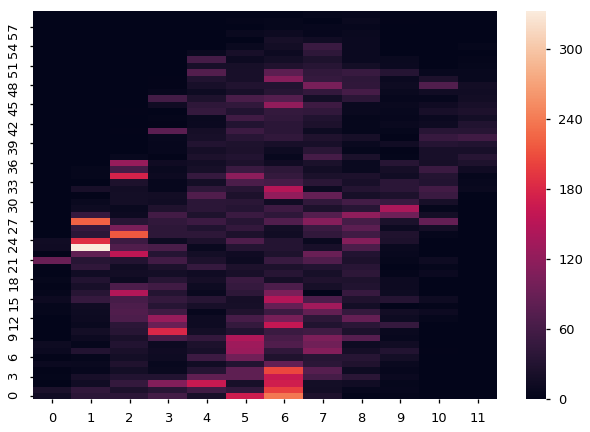

In [2]:
dataset = data.get_data('datasets/results-20171101-101319.csv', name="raw_coordinates")
with tf.Session() as sess:
    rotated_data = sess.run(data.rotate(dataset, np.pi * 0.0))
H = data.bin_2d(rotated_data.T, [60, 12], pad_longitude=0.0, pad_latitude=0.0)
ax = sns.heatmap(H[0])
ax.invert_yaxis()
# sns.jointplot(rotated_data.T[:, 0], rotated_data.T[:, 1])

Now lets look at a single bin, over the course of several hours throughout the day. Specifically, lets look at the busy point around 30th street and Ninth Avenue.

In [4]:
utils.
max_cars_in_bin = H[0].max()
np.argwhere(H[0] == max_cars_in_bin)
# utils.get_bin_indices(num_cars_in_bin)
# num_avenues = 12
# max_cars = H[0].max()
# street = H[0].argmax() // num_avenues
# ave = H[0][street].argmax()
# print("The busiest Intersection is", num_avenues - ave, "ave and", street, "street with", max_cars, "pickups or dropoffs")

[[23  1]]


In [81]:
print("The coordinates surrounding the busiest intersection are")
ave_min_long = H[2][ave]
ave_max_long = H[2][ave + 1]
street_min_lat = H[1][street]
street_max_lat = H[1][street + 1]
print(f"[{ave_min_long}, {ave_max_long}], [{street_min_lat}, {street_max_lat}]")
trips_in_busy_point = []
count = 0
for i in rotated_data.T:
    longitude = i[0]
    latitude = i[1]
    if longitude > ave_min_long and longitude < ave_max_long and latitude > street_min_lat and latitude < street_max_lat:
            trips_in_busy_point.append(i)

The coordinates surrounding the busiest intersection are
[-74.00848388671875, -74.00474548339844], [40.73967742919922, 40.74059295654297]
331


## Model

Here, we define a placeholder `X`. During inference, we pass in
the value for this placeholder according to data.

## Inference

Perform variational inference.
Define the variational model to be a fully factorized normal.

In [5]:
qf = Normal(loc=tf.Variable(tf.random_normal([N])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([N]))))

Run variational inference for `500` iterations.

In [6]:
inference = ed.KLqp({f: qf}, data={X: X_train, y: y_train})
inference.run(n_iter=5000)

5000/5000 [100%] ██████████████████████████████ Elapsed: 9s | Loss: 82.755


In this case
`KLqp` defaults to minimizing the
$\text{KL}(q\|p)$ divergence measure using the reparameterization
gradient.
For more details on inference, see the [$\text{KL}(q\|p)$ tutorial](/tutorials/klqp).
(This example happens to be slow because evaluating and inverting full
covariances in Gaussian processes happens to be slow.)